In [1]:
# ---------- Imports ----------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.spatial as sp

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# -------------------------------------
# ---------- Bounded Voronoi ----------
# -------------------------------------
# Code from: https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells

# ---------- Functions ----------
def in_box(towers, bounding_box):
    # Returns a new np.array of towers that within the bounding_box
    # bounding_box = [x_min, x_max, y_min, y_max]
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def bounded_voronoi(towers, bounding_box):
    # Generates a bounded vornoi diagram with finite regions
    # bounding_box = [x_min, x_max, y_min, y_max]

    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)

    # Mirror points left, right, above, and under to force finite regions
    points_center = towers[i, :]

    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])

    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])

    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])

    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])

    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)

    # Compute Voronoi
    vor = sp.Voronoi(points)

    # creates a new attibute for points that form the diagram within the region
    vor.filtered_points = points_center
    # grabs the first fifth of the regions, which are the original regions
    vor.filtered_regions = np.array(vor.regions, dtype=object)[vor.point_region[:vor.npoints//5]]
    
    return vor

# Finds the centroid of a region. First and last point should be the same.
def centroid_region(vertices):
    # Polygon's signed area
    A = 0
    # Centroid's x
    C_x = 0
    # Centroid's y
    C_y = 0
    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A = A + s
        C_x = C_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        C_y = C_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    A = 0.5 * A
    C_x = (1.0 / (6.0 * A)) * C_x
    C_y = (1.0 / (6.0 * A)) * C_y
    return np.array([[C_x, C_y]])


# Performs x iterations of loyd's algorithm to calculate a centroidal vornoi diagram
def generate_CVD(points, iterations, bounding_box):
    p = np.copy(points)

    for i in range(iterations):
        vor = bounded_voronoi(p, bounding_box)
        centroids = []

        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :] # grabs vertices for the region and adds a duplicate of the first one to the end
            centroid = centroid_region(vertices)
            centroids.append(list(centroid[0, :]))

        p = np.array(centroids)

    return bounded_voronoi(p, bounding_box)


def plot_vornoi_diagram(fig, vor, bounding_box, plotInitPts = False, plotRidgePts = True, plotRidge = True):
    # Plots voronoi data (vor) onto pyplot (fig)
    # bounding_box = [x_min, x_max, y_min, y_max]
    ax = fig.gca()

    # Plot initial points
    if plotInitPts:
        ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], '+r', label = 'Gauss Centres')
        
    for i, pnt in enumerate(vor.filtered_points):
        ax.annotate(str(i), (pnt))

    # Plot ridges points
    if plotRidgePts:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region, :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'go', label = 'Ridges Points' if first else '')
            first = False

    # Plot ridges
    if plotRidge:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'k-', label = 'Ridges' if first else '')
            first = False

    # Tidy details 
    margin_percent = .1
    width = bounding_box[1]-bounding_box[0]
    height = bounding_box[3]-bounding_box[2]

    ax.set_xlim([bounding_box[0]-width*margin_percent, bounding_box[1]+width*margin_percent])
    ax.set_ylim([bounding_box[2]-height*margin_percent, bounding_box[3]+height*margin_percent])
    ax.legend()

    return fig

def plot_patch(fig, vor, colour, cellsIndices, label = ''):
    ax = fig.gca()

    first = True
    for cellsIndex in cellsIndices:
        region = vor.filtered_regions[cellsIndex]
        vertices = vor.vertices[region + [region[0]], :]
        ax.add_patch(Polygon(vertices, closed=True, facecolor=colour, alpha=0.5, label = label if first else ''))
        first = False
        
    ax.legend()
        
    return fig

In [3]:
class problem:
    def __init__(self):
        self.regions = []
        self.direction = [1.0, 0.0]
        self.upstreamTracker = []
        self.completed = []
        self.available = []
        
    def addData(self, vor):
        self.regions = [{'neighbours':[],'normalDirs':[],'midpoints':[],'upStreamNbs':[],'downStreamNbs':[]} for region in vor.filtered_regions]
        numRegs = len(vor.filtered_regions)
        
        for i, ridge in enumerate(vor.ridge_points):
            regionA = ridge[0]
            regionB = ridge[1]
            if ((regionA < numRegs) and (regionB < numRegs)):
                ridgeVerts = vor.ridge_vertices[i]
                vertexA = vor.vertices[ridgeVerts[0]]
                vertexB = vor.vertices[ridgeVerts[1]]
                midPoint = 0.5*(vertexA + vertexB)
                
    
                regionACent = vor.points[regionA]
                regionBCent = vor.points[regionB]
                dx = regionBCent[0] - regionACent[0]
                dy = regionBCent[1] - regionACent[1]
                normal = [dx, dy]
                
                self.regions[regionA]['neighbours'].append(regionB)
                self.regions[regionA]['normalDirs'].append(normal)
                self.regions[regionA]['midpoints'].append(midPoint)
                
                normal = [-dx, -dy]
                self.regions[regionB]['neighbours'].append(regionA)
                self.regions[regionB]['normalDirs'].append(normal)
                self.regions[regionB]['midpoints'].append(midPoint)
                
    def addDirection(self, direction):
        self.direction = direction
        for i, region in enumerate(self.regions):
            for j, nbr in enumerate(region['neighbours']):
                downstream = np.sign(np.dot(direction, region['normalDirs'][j]))
                if (downstream == 1.0):
                    region['upStreamNbs'].append(0)
                    region['downStreamNbs'].append(nbr)
                else:
                    region['upStreamNbs'].append(1)
                    
    def initSweep(self):
        for region in self.regions:
            self.upstreamTracker.append(np.sum(region['upStreamNbs']))
            
        self.refreshAvailable()
            
    def refreshAvailable(self):
        self.available = [index for index, element in enumerate(self.upstreamTracker) if element == 0]
            
    def plotProgress(self, fig, vor):
        plot_patch(fig, vor, 'aqua', self.completed, label = 'completed')
        plot_patch(fig, vor, 'crimson', self.available, label = '0 upstream / available')
        
        indices = [index for index, element in enumerate(self.upstreamTracker) if element == 1]
        plot_patch(fig, vor, 'khaki', indices, label = '1 upstream')
        
        indices = [index for index, element in enumerate(self.upstreamTracker) if element == 2]
        plot_patch(fig, vor, 'gold', indices, label = '2 upstream')
        
        indices = [index for index, element in enumerate(self.upstreamTracker) if element == 3]
        plot_patch(fig, vor, 'darkorange', indices, label = '3 upstream')
        
        indices = [index for index, element in enumerate(self.upstreamTracker) if element >= 4]
        plot_patch(fig, vor, 'peru', indices, label = '4+ upstream')
        
    def stepSingle(self, index):
        if index not in self.available:
            print('ERROR!')
            return
        
        self.completed.append(index)

        self.upstreamTracker[index] = self.upstreamTracker[index] - 1
        for dwnStrmNb in self.regions[index]['downStreamNbs']:
            self.upstreamTracker[dwnStrmNb] = self.upstreamTracker[dwnStrmNb] - 1
        
        
    def step(self, indices = [], msg = ''):
        if msg == 'done':
            print(self.completed)
            return
        elif msg == 'options':
            print(self.available)
            return
        elif ((msg == 'all') or ((msg == '') and (indices == []))):
            indices = self.available
#         elif msg == 'best' # TODO: furthest back in direction of sweep?
        
        for index in indices:
            self.stepSingle(index)
            
        self.refreshAvailable()

    def nBatch(self, n):
        for i in range(n):
#             self.step(msg = 'options')
            self.step()
            
    def allBatch(self):
        furtherWork = True
        while furtherWork:
#             self.step(msg = 'options')
            self.step()
            
            if self.available == []:
                furtherWork = False
                
    def plotDag(self, fig):
        ax = fig.gca()
        dirNorm = self.direction / np.linalg.norm(self.direction)
        
        arrowMids = []
        
        for i in range(12):
            arrowMids.append([-0.05 + i*0.1, 1.05])
            arrowMids.append([-0.05 + i*0.1, -0.05])
            arrowMids.append([1.05, -0.05 + i*0.1])
            arrowMids.append([-0.05, -0.05 + i*0.1])
        
        for arrowMid in arrowMids:
            arrowBase = arrowMid - (dirNorm / 25.0)
            arrowHead = arrowMid + (dirNorm / 25.0)
            ax.annotate("", xy=arrowHead, xytext=arrowBase, arrowprops=dict(arrowstyle='->', color='black'))
        
        for region in self.regions:
            for i, neighbour in enumerate(region['neighbours']):
                if region['upStreamNbs'][i] == 0:
                    arrowBase = region['midpoints'][i]
                    arrowDir = region['normalDirs'][i]
                    arrowDirNrm = arrowDir / (40 * np.linalg.norm(arrowDir))
                    arrowHead = arrowBase + arrowDirNrm
                    ax.annotate("", xy=arrowHead, xytext=arrowBase, arrowprops=dict(arrowstyle='->', color='red'))
        
        return fig

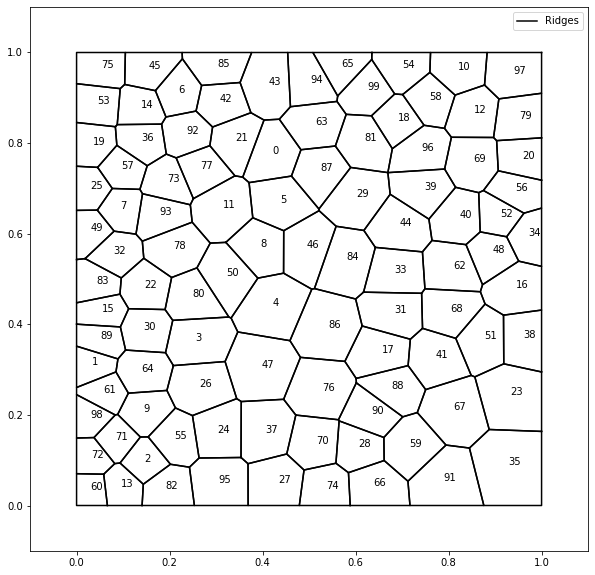

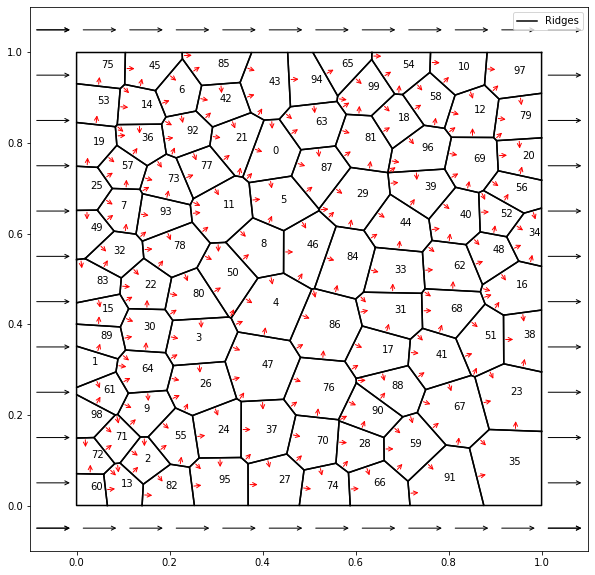

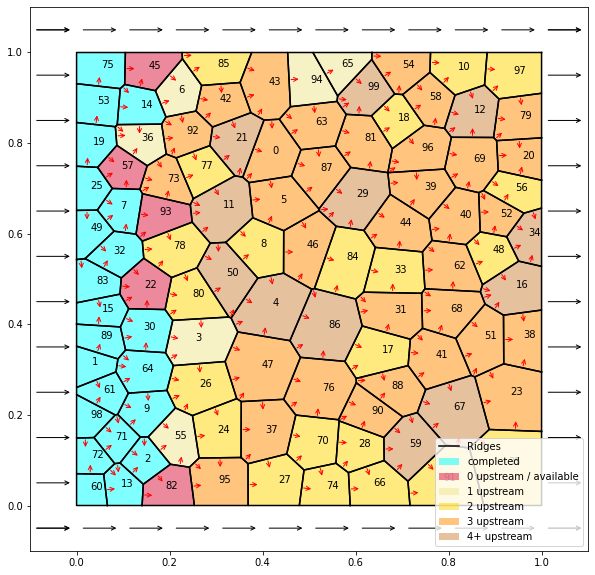

In [4]:
# 
theta = 0
n_towers = 100
bounding_box = np.array([0., 1., 0., 1.]) # [x_min, x_max, y_min, y_max]

# 
np.random.seed(1)
towers = np.random.rand(n_towers, 2)
vor = generate_CVD(towers, 3, bounding_box)


fig = plt.figure()
fig = plot_vornoi_diagram(fig, vor, bounding_box, False, False)
plt.show(fig)
fig = plt.figure(fig)


prob = problem()
prob.addData(vor)
prob.addDirection([np.cos(theta), np.sin(theta)])

prob.plotDag(fig)
plt.show(fig)
fig = plt.figure(fig)

prob.initSweep()
prob.nBatch(5)

prob.plotProgress(fig, vor)
plt.show(fig)